<a href="https://colab.research.google.com/github/danaderp/DeepLearningTutorials/blob/master/WmdSimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#danaderp Oct'21 2019
#Using WMD Word Mover's Distance to compute document similarity

In [0]:
from time import time
start_nb = time()

In [73]:
# Import and download stopwords from NLTK.
import json
import operator
from nltk.corpus import stopwords
from nltk import download
download('stopwords')  # Download stopwords list.

# Remove stopwords.
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
from nltk import word_tokenize
download('punkt')  # Download data for tokenizer.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
import os
import gensim.models as gm
from gensim.models import Word2Vec
from gensim.similarities import WmdSimilarity

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

In [51]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Initialize logging.
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')

In [0]:
sentence_obama = 'Obama speaks to the media in Illinois'
sentence_president = 'The president greets the press in Chicago'
sentence_obama = sentence_obama.lower().split()
sentence_president = sentence_president.lower().split()

In [0]:
sentence_obama = [w for w in sentence_obama if w not in stop_words]
sentence_president = [w for w in sentence_president if w not in stop_words]

In [0]:
start = time()
if not os.path.exists('/content/gdrive/My Drive/Colab Notebooks/MiningArticles/GoogleNews-vectors-negative300.bin.gz'):
    raise ValueError("SKIP: You need to download the google news model")

In [0]:
#model = Word2Vec.load_word2vec_format('/content/gdrive/My Drive/Colab Notebooks/MiningArticles/GoogleNews-vectors-negative300.bin.gz', binary=True)
model = gm.KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Colab Notebooks/MiningArticles/GoogleNews-vectors-negative300.bin.gz', binary=True)
print('Cell took %.2f seconds to run.' % (time() - start))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Cell took 150.90 seconds to run.


In [55]:
#Computing Distance
distance = model.wmdistance(sentence_obama, sentence_president)
print('distance = %.4f' % distance)

distance = 1.0175


In [56]:
#Unrelated Sentence
sentence_orange = 'Oranges are my favorite fruit'
sentence_orange = sentence_orange.lower().split()
sentence_orange = [w for w in sentence_orange if w not in stop_words]

distance = model.wmdistance(sentence_obama, sentence_orange)
print('distance = %.4f' % distance)

distance = 1.3663


#Normalizing word2vec vectors
When using the wmdistance method, it is beneficial to normalize the word2vec vectors first, so they all have equal length. To do this, simply call model.init_sims(replace=True) and Gensim will take care of that for you.
Note that normalizing the vectors can take some time, especially if you have a large vocabulary and/or large vectors.

In [0]:
# Normalizing word2vec vectors.
start = time()

model.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.

distance = model.wmdistance(sentence_obama, sentence_president)  # Compute WMD as normal.

print ('Cell took %.2f seconds to run.' %(time() - start))

Cell took 26.08 seconds to run.


# Similarity queries using WmdSimilarity
WMD is a measure of distance. The similarities in WmdSimilarity are simply the negative distance. Be careful not to confuse distances and similarities. Two similar documents will have a high similarity score and a small distance; two very different documents will have low similarity score, and a large distance.

In [0]:
#This preprocessing is not optimized for source code analysis
def preprocess(doc):
    doc = doc.lower()  # Lower the text.
    doc = word_tokenize(doc)  # Split into words.
    doc = [w for w in doc if not w in stop_words]  # Remove stopwords.
    doc = [w for w in doc if w.isalpha()]  # Remove numbers and punctuation.
    return doc

In [0]:
if not os.path.exists('/content/gdrive/My Drive/Colab Notebooks/MiningArticles/review.json'):
    raise ValueError("SKIP: You need to download the json file")

In [0]:
#Counting The Reviews
review_counts = set()
business = set()
with open('/content/gdrive/My Drive/Colab Notebooks/MiningArticles/review.json') as data_file:
    for line in data_file:
      json_line = json.loads(line)
      business.add(json_line['business_id'])
      review_counts.add((json_line['business_id'],json_line['review_id']))

In [0]:
d = dict.fromkeys(business, 0)

In [0]:
for rew in review_counts:
  d[rew[0]] = d[rew[0]] + 1

In [0]:
sorted_d = sorted(d.items(), key=operator.itemgetter(1))

In [85]:
#The restaurants we chose were those with the highest number of reviews in the Yelp dataset.
print(sorted_d[-7:-1])
# Business IDs of the restaurants.
ids = [i[0] for i in sorted_d[-7:-1]]

[('2weQS-RnoOBhb1KsHKyoSQ', 4534), ('DkYS3arLOhA8si5uUEmHOw', 5206), ('cYwJA2A6I12KNkm2rtXd5g', 5575), ('f4x1YBxkLrZg652xt2KR5g', 5847), ('K7lWdNUhCbcnEvI0NhGewg', 6887), ('RESDUcs7fIiihp38-d6_6g', 8568)]


In [86]:
start = time()
# Business IDs of the restaurants.

w2v_corpus = []  # Documents to train word2vec on (all 6 restaurants).
wmd_corpus = []  # Documents to run queries against (only one restaurant).
documents = []  # wmd_corpus, with no pre-processing (so we can see the original documents).
with open('/content/gdrive/My Drive/Colab Notebooks/MiningArticles/review.json') as data_file:
    for line in data_file:
      
      json_line = json.loads(line)
      
      if json_line['business_id'] not in ids:
         # Not one of the 6 restaurants.
         continue
        
      # Pre-process document.
      text = json_line['text']  # Extract text from JSON object.
      text = preprocess(text)
      
      # Add to corpus for training Word2Vec.
      w2v_corpus.append(text)
        
      if json_line['business_id'] == ids[0]:
          # Add to corpus for similarity queries.
          wmd_corpus.append(text)
          documents.append(json_line['text'])

print ('Cell took %.2f seconds to run.' %(time() - start))

Cell took 185.15 seconds to run.


In [97]:
print(len(w2v_corpus))

36617


In [0]:
# Document lengths.
lens = [len(doc) for doc in wmd_corpus]

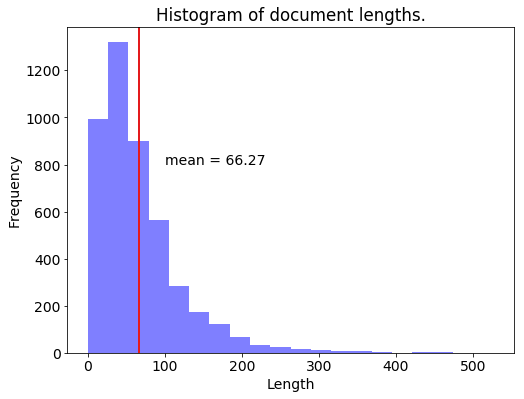

In [96]:
num_bins = 20
n, bins, patches = plt.hist(lens, num_bins, facecolor='blue', alpha=0.5)

# Average length.
avg_len = sum(lens) / float(len(lens))
plt.axvline(avg_len, color='#e41a1c')
plt.text(100, 800, 'mean = %.2f' % avg_len)

plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title(r'Histogram of document lengths.')
plt.figsize=(8,6)

plt.show()

In [0]:
##Training a model
# Train Word2Vec on all the restaurants.
model = Word2Vec(w2v_corpus, workers=3, size=100)

In [0]:
# Initialize WmdSimilarity.
num_best = 10 #how many results the queries return
instance = WmdSimilarity(wmd_corpus, model, num_best=num_best)

In [102]:
start = time()

sent = 'Very good, you should seat outdoor.'
query = preprocess(sent)

sims = instance[query]  # A query is simply a "look-up" in the similarity class.

print ('Cell took %.2f seconds to run.' %(time() - start))

Cell took 32.22 seconds to run.
